In [2010]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from data.encoder import Encoder
import missingno as msno
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from analyzer.stat_criterion.stat_criteria import StatCriteria
from analyzer.metric import MetricCalculator
from data.io import Reader, Saver
from data.plot import Drawer
import seaborn as sns
from analyzer.stat_criterion.analyser_timeseries_custom import AnalyserTimeSeriesCustom
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Постановка задачи

Коэффициент Джини (индекс Джини, или «индекс справедливости») — показатель, отражающий степень неравенства в распределении доходов внутри различных групп населения. Коэффициент в 1912 году разработал итальянский статистик Коррадо Джини. Показатель принимает значения от 0 (в случае абсолютного равенства) до 1 (в случае абсолютного неравенства).

1. Предскажите коэффициент Джини для России на 2021
2. Найдите страну на постсоветском пространстве у которой коэф.Джини наименьший
3. Определите для каждого десятилетия средний уровень коэф.Джини для всех стран и постройте столбчатую диаграмму
4. Добавить столбец регион (подумайте как это сделать проще всего)
5. Определите изменение коэффицинта Джини по регионам
6. Найдите страну с наименьшим коэф.Джини на протяжении всей истории наблюдений (есть ли такая вообще)

датасет: https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA210_Test_4.csv

# Выгрузка и проверка целостности датасета

In [2011]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA210_Test_4.csv")
Saver.save_csv(df_original, "PDA210_Control_Test_4", False)
df = df_original.copy().reset_index(drop=True)
df['value'] = df['value'] / 100
df.head(10)

Файл успешно сохранён: ./dataset/PDA210_Control_Test_4.csv


,country_code,country_name,year,value
0,GMB,"Gambia, The",1998,0.485
1,ARG,Argentina,1994,0.459
2,SWE,Sweden,1981,0.229
3,CHL,Chile,1998,0.555
4,ARM,Armenia,2014,0.315
5,HND,Honduras,2011,0.526
6,SWE,Sweden,2000,0.272
7,ARM,Armenia,2001,0.354
8,DEU,Germany,2016,0.316
9,ARG,Argentina,1997,0.491


In [2012]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896 entries, 0 to 1895
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  1896 non-null   object 
 1   country_name  1896 non-null   object 
 2   year          1896 non-null   int64  
 3   value         1896 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 59.4+ KB


## пропуски в данных

In [2013]:
# посмотрим на пропуски в данных
df.isna().sum()

country_code    0
country_name    0
year            0
value           0
dtype: int64

<Axes: >

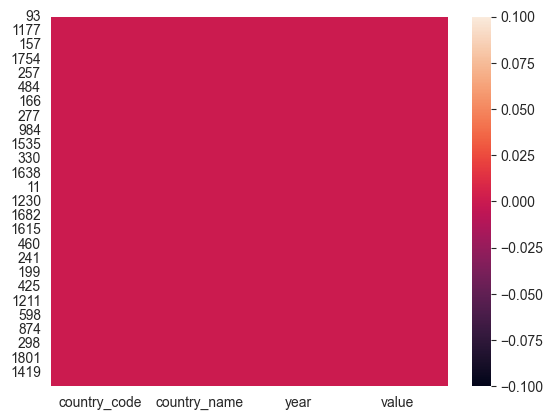

In [2014]:
# Посмотрим на пропуски
sns.heatmap(df.sort_values(by='year').isna())

<Axes: >

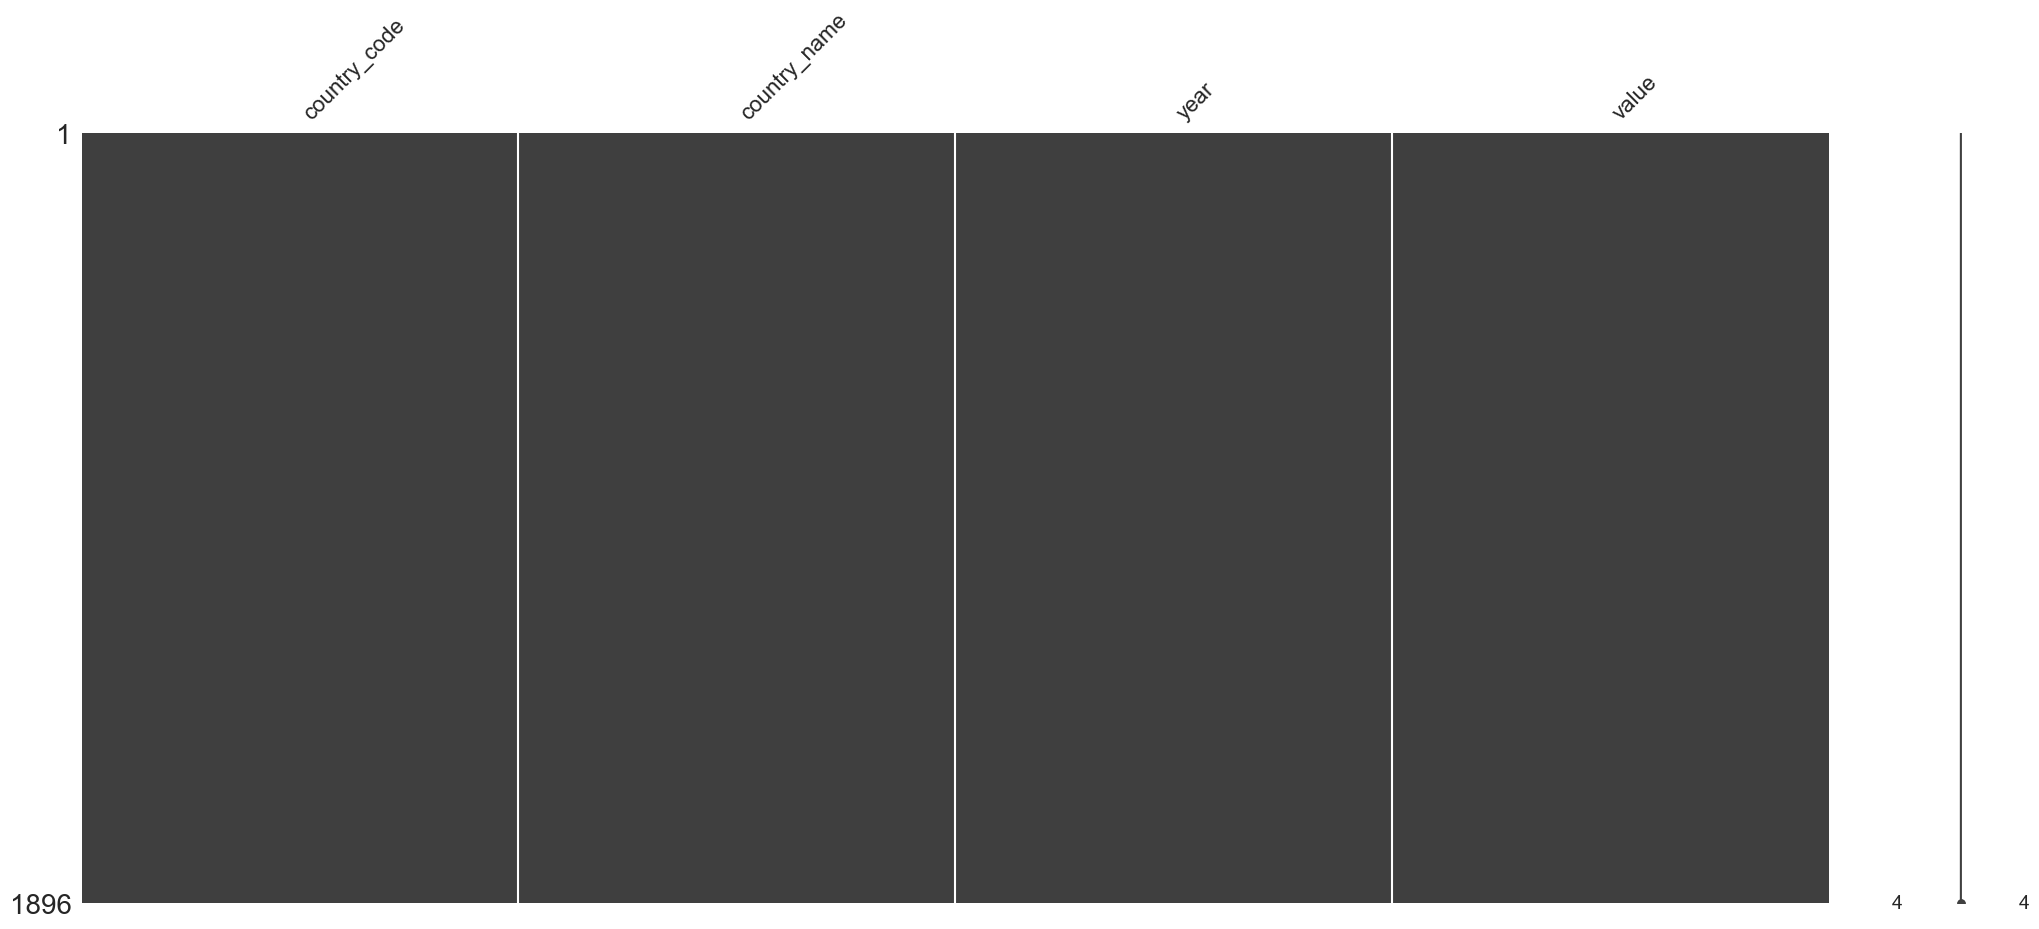

In [2015]:
# Посмотрим на пропуски
msno.matrix(df)

## выявление неестественных значений

In [2016]:
# Посмотрим статистику о датасете
df.describe()

,year,value
count,1896.000000,1896.000000
mean,2006.275844,0.381793
std,9.348789,0.090776
min,1967.000000,0.202000
25%,2000.750000,0.312000
50%,2008.000000,0.361000
75%,2014.000000,0.441000
max,2021.000000,0.658000


# Ответы на вопросы

## предскажите коэффициент Джини для России на 2021

In [2017]:
mask = df['country_name'] == 'Russian Federation'

df_RF = df[mask].sort_values(by='year', ascending=False)
df_RF.head(10)

,country_code,country_name,year,value
1833,RUS,Russian Federation,2020,0.360
64,RUS,Russian Federation,2019,0.377
154,RUS,Russian Federation,2018,0.375
626,RUS,Russian Federation,2017,0.372
1797,RUS,Russian Federation,2016,0.368
1062,RUS,Russian Federation,2015,0.377
919,RUS,Russian Federation,2014,0.399
1817,RUS,Russian Federation,2013,0.409
1411,RUS,Russian Federation,2012,0.407
1570,RUS,Russian Federation,2011,0.397


Прогноз на следующий год: 0.3548


C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

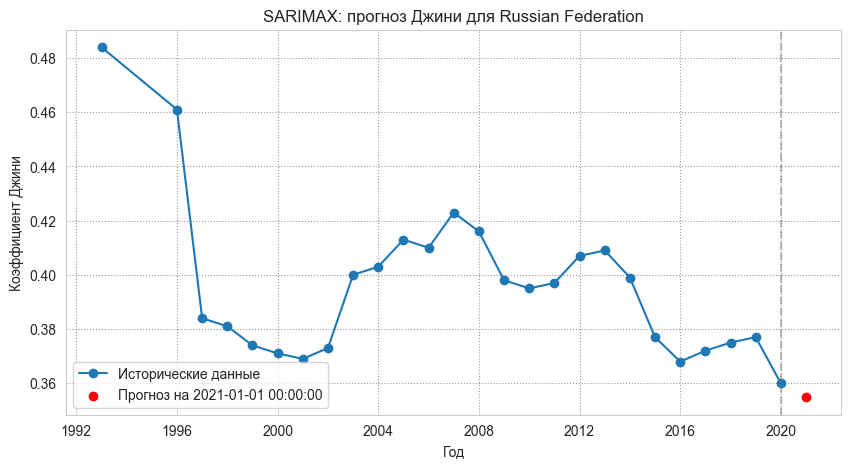

In [2018]:
df_RF.drop(columns=['country_code', 'country_name'], axis=1, inplace=True)

df_RF.sort_values('year', inplace=True)
df_RF['year'] = pd.to_datetime(df_RF['year'], format="%Y")
df_RF.set_index('year', inplace=True)
series = df_RF['value']

series.index = pd.to_datetime(series.index)

model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit(disp=False)

# Прогноз на 1 год вперёд
forecast = results.get_forecast(steps=1)
predicted_value = forecast.predicted_mean.iloc[0]
conf_int = forecast.conf_int()

print(f"Прогноз на следующий год: {predicted_value:.4f}")

x_forecast = series.index[-1] + pd.DateOffset(years=1)

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(series, label="Исторические данные", marker='o')
plt.axvline(series.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.scatter(x_forecast, predicted_value, color='red', label=f"Прогноз на {x_forecast}")
plt.legend()
plt.title(f"SARIMAX: прогноз Джини для Russian Federation")
plt.xlabel("Год")
plt.ylabel("Коэффициент Джини")
plt.show()

## найдите страну на постсоветском пространстве у которой коэф.Джини наименьший

In [2019]:
# находим данные на последний год
gini_by_country = df.groupby('country_name')['value'].last().sort_values().reset_index()
gini_by_country.head(10)

,country_name,value
0,Ukraine,0.246
1,Slovak Republic,0.252
2,Iceland,0.254
3,Slovenia,0.254
4,Czechia,0.259
5,United Arab Emirates,0.260
6,Norway,0.260
7,Albania,0.270
8,Hungary,0.270
9,Denmark,0.273


In [2020]:
post_soviet_countries = [
    "Russian Federation",
    "Ukraine",
    "Belarus",
    "Kazakhstan",
    "Armenia",
    "Georgia",
    "Azerbaijan",
    "Uzbekistan",
    "Kyrgyzstan",
    "Tajikistan",
    "Turkmenistan",
    "Moldova",
    "Lithuania",
    "Latvia",
    "Estonia",
]

mask = gini_by_country['country_name'].isin(post_soviet_countries)
gini_post_soviet = gini_by_country[mask].sort_values(by = 'value')

gini_post_soviet.head(10)

,country_name,value
0,Ukraine,0.246
14,Kazakhstan,0.285
18,Belarus,0.288
47,Tajikistan,0.336
48,Armenia,0.336
61,Azerbaijan,0.347
63,Moldova,0.349
65,Estonia,0.351
67,Uzbekistan,0.353
72,Latvia,0.356


## определите для каждого десятилетия средний уровень коэф.Джини для всех стран и постройте столбчатую диаграмму

In [2021]:
df['decade'] = (df['year'] // 10) * 10

In [2022]:
gini_decade_country = df.groupby(['country_name', 'decade'])['value'].mean().reset_index()

gini_decade_country.head(10)

,country_name,decade,value
0,Albania,1990,0.270000
1,Albania,2000,0.307667
2,Albania,2010,0.320143
3,Algeria,1980,0.402000
4,Algeria,1990,0.353000
5,Algeria,2010,0.276000
6,Angola,2000,0.473500
7,Angola,2010,0.513000
8,Argentina,1980,0.429667
9,Argentina,1990,0.479000


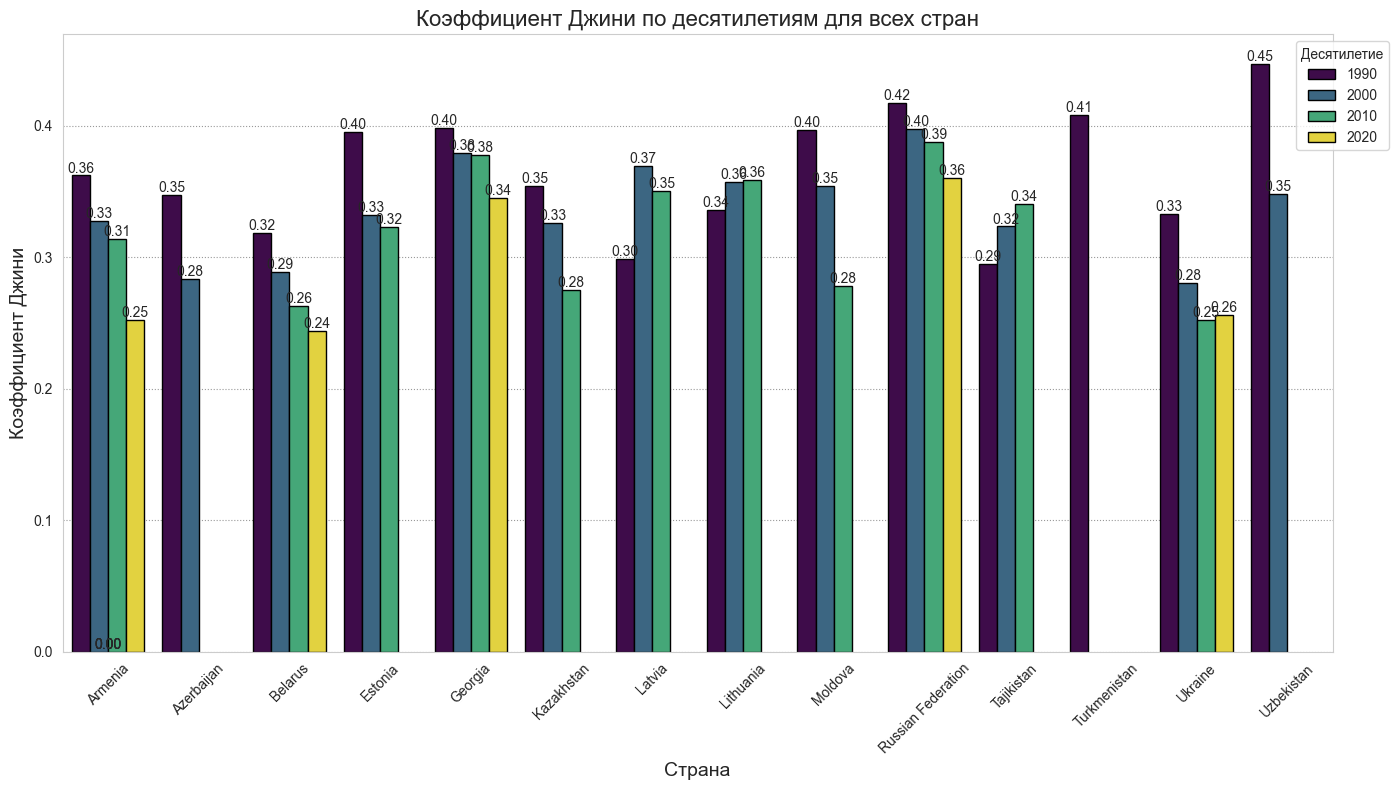

In [2023]:
plt.figure(figsize=(14, 8))

mask = gini_decade_country['country_name'].isin(post_soviet_countries)

sns.barplot(
    data=gini_decade_country[mask],
    x='country_name',
    y='value',
    hue='decade',
    palette='viridis',
    edgecolor='black'
)

plt.title('Коэффициент Джини по десятилетиям для всех стран', fontsize=16)
plt.xlabel('Страна', fontsize=14)
plt.ylabel('Коэффициент Джини', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Десятилетие', bbox_to_anchor=(1.05, 1))

# Добавляем подписи значений
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 5), textcoords='offset points'
    )

plt.tight_layout()
plt.show()

## добавить столбец регион (подумайте как это сделать проще всего)

In [2024]:
# url = "https://restcountries.com/v3.1/all"
#
# try:
#     response = requests.get(url, timeout=10, verify=False)
#     response.raise_for_status()
#     data = response.json()
#
#     with open("countries.json", "w", encoding="utf-8") as f:
#         json.dump(data, f, ensure_ascii=False, indent=2)
#
# except requests.exceptions.RequestException as e:
#     print(f"Не удалось загрузить данные с API: {e}")

In [2025]:
with open('countries.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

country_region_mapping = {
    country.get('cca3', ''): country.get('region', 'Unknown')
    for country in data
}

def get_region(country_name):
    return country_region_mapping.get(country_name, "Unknown")

df['region'] = df['country_code'].apply(get_region)
df.head(10)

,country_code,country_name,year,value,decade,region
0,GMB,"Gambia, The",1998,0.485,1990,Africa
1,ARG,Argentina,1994,0.459,1990,Americas
2,SWE,Sweden,1981,0.229,1980,Europe
3,CHL,Chile,1998,0.555,1990,Americas
4,ARM,Armenia,2014,0.315,2010,Asia
5,HND,Honduras,2011,0.526,2010,Americas
6,SWE,Sweden,2000,0.272,2000,Europe
7,ARM,Armenia,2001,0.354,2000,Asia
8,DEU,Germany,2016,0.316,2010,Europe
9,ARG,Argentina,1997,0.491,1990,Americas


In [2026]:
mask = df['region'] == 'Unknown'
df[mask]['country_name'].unique()

array(['Kosovo'], dtype=object)

In [2027]:
mask = df['country_name'] == 'Kosovo'
df['region'] = df['region'].mask(mask, 'Europe')

In [2028]:
mask = df['region'] == 'Unknown'
df[mask]['country_name'].unique()

array([], dtype=object)

## определите изменение коэффицинта Джини по регионам

In [2029]:
gini_region = df.groupby(['region', 'year'])['value'].mean().reset_index()

gini_region.head(10)

,region,year,value
0,Africa,1980,0.468000
1,Africa,1984,0.392000
2,Africa,1985,0.454500
3,Africa,1986,0.470000
4,Africa,1987,0.399000
5,Africa,1988,0.377000
6,Africa,1989,0.444000
7,Africa,1990,0.371333
8,Africa,1991,0.470200
9,Africa,1992,0.448571


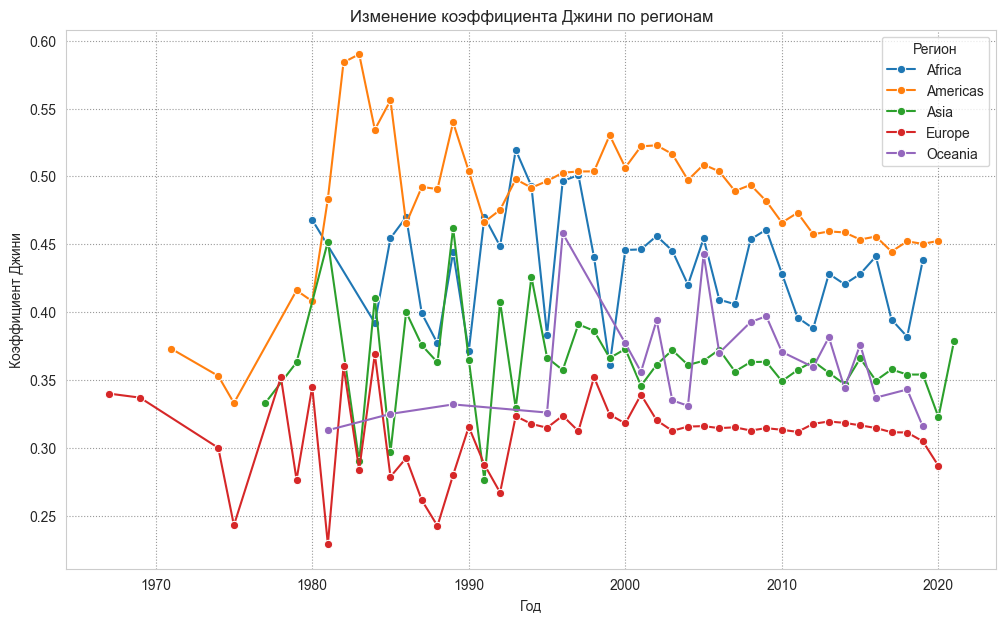

In [2030]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=gini_region, x='year', y='value', hue='region', marker='o')

plt.title('Изменение коэффициента Джини по регионам')
plt.xlabel('Год')
plt.ylabel('Коэффициент Джини')
plt.legend(title='Регион')
plt.grid(True)
plt.show()

## найдите страну с наименьшим коэф.Джини на протяжении всей истории наблюдений (есть ли такая вообще)

In [2031]:
df.sort_values(by='value', ascending=True)

,country_code,country_name,year,value,decade,region
1767,SVK,Slovak Republic,1992,0.202,1990,Europe
1214,CZE,Czechia,1992,0.207,1990,Europe
1045,HUN,Hungary,1987,0.210,1980,Europe
949,FIN,Finland,1987,0.222,1980,Europe
1409,HRV,Croatia,1988,0.228,1980,Europe
...,...,...,...,...,...,...
116,NAM,Namibia,2003,0.633,2000,Africa
1002,ZAF,South Africa,2010,0.634,2010,Africa
1755,BWA,Botswana,2002,0.647,2000,Africa
836,ZAF,South Africa,2005,0.648,2000,Africa


# Первичный визуальный анализ зависимостей в данных

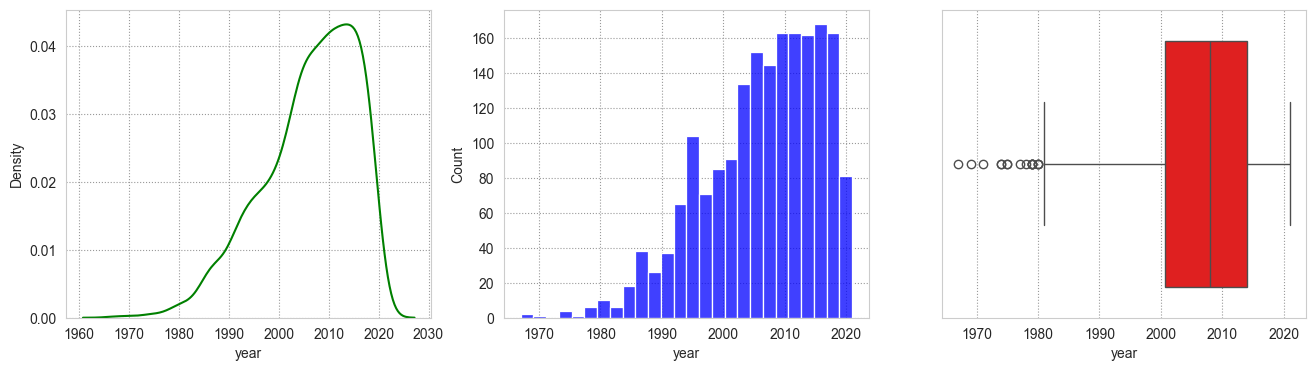

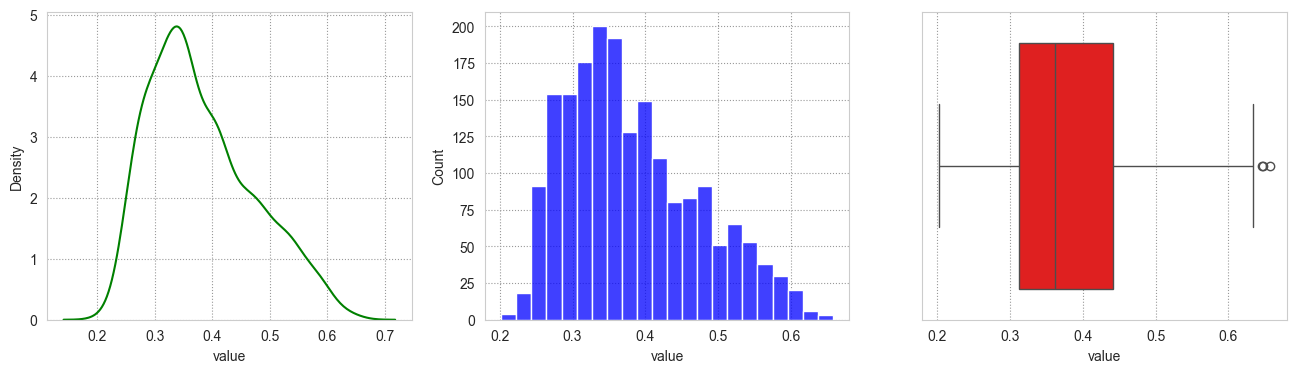

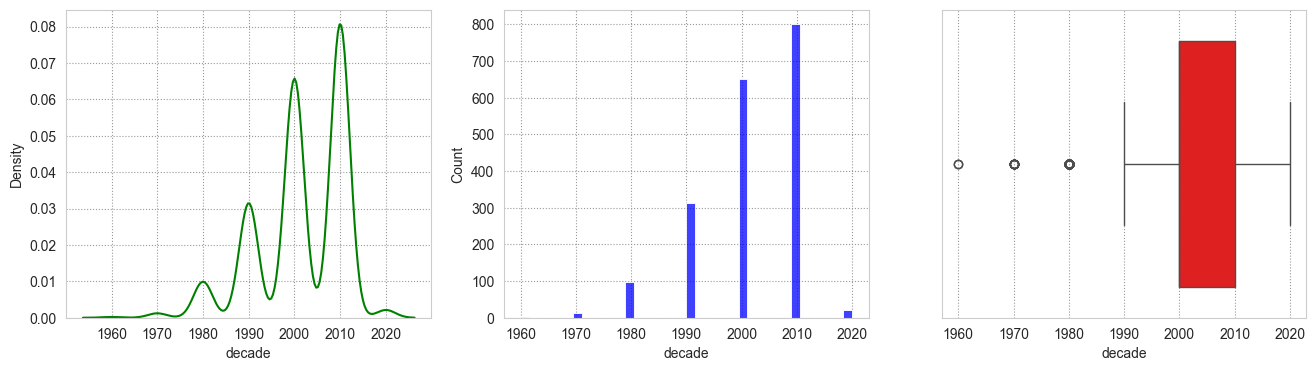

In [2032]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

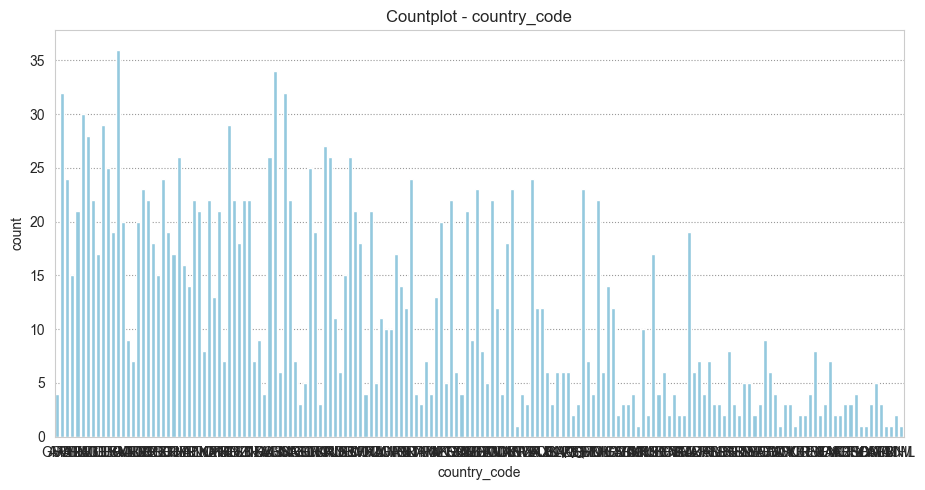

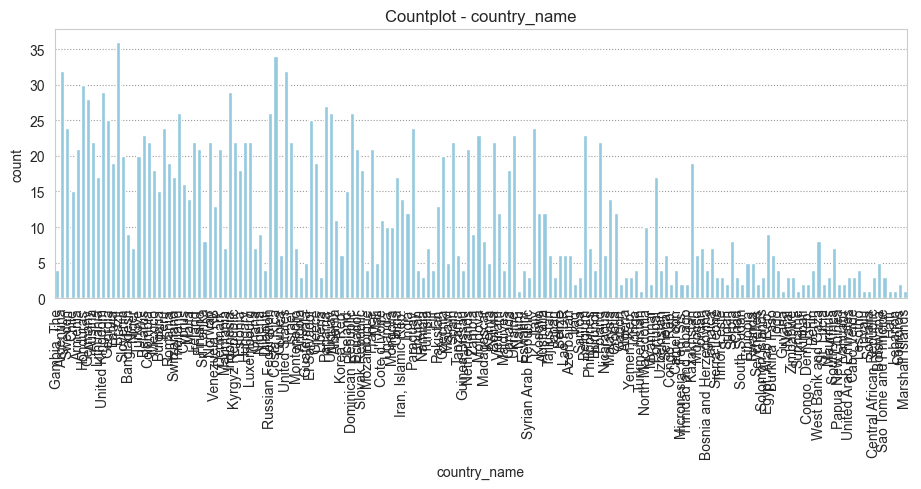

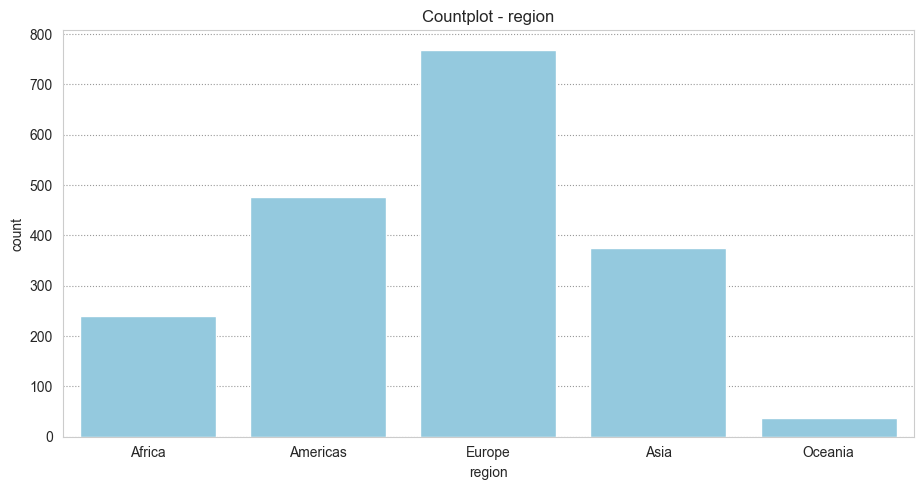

In [2033]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

# Анализ взаимосвязей в данных

## подготовка временного ряда

In [2034]:
df.drop(columns='country_name', axis=1, inplace=True)

In [2035]:
df.index = pd.to_datetime(df['year'], format='%Y') 
df.sort_index(inplace=True)

target = ['value']

period = 5

## проверка на стационарность

In [2036]:
def test_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print(f"p-value: {result[1]:.3f}")

    if result[1] < 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

test_stationarity(df[target])

p-value: 0.000
Ряд стационарен.


In [2037]:
def test_kpss(series):
    result = kpss(series, regression='ct', nlags="auto")
    print(f"p-value: {result[1]:.3f}")

    if result[1] < 0.05:
        print("Ряд не стационарен.")
    else:
        print("Ряд стационарен.")

test_kpss(df[target])

p-value: 0.010
Ряд не стационарен.


C:\Users\Tikhon\AppData\Local\Temp\ipykernel_1396\3876179710.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='ct', nlags="auto")


## декомпозиция

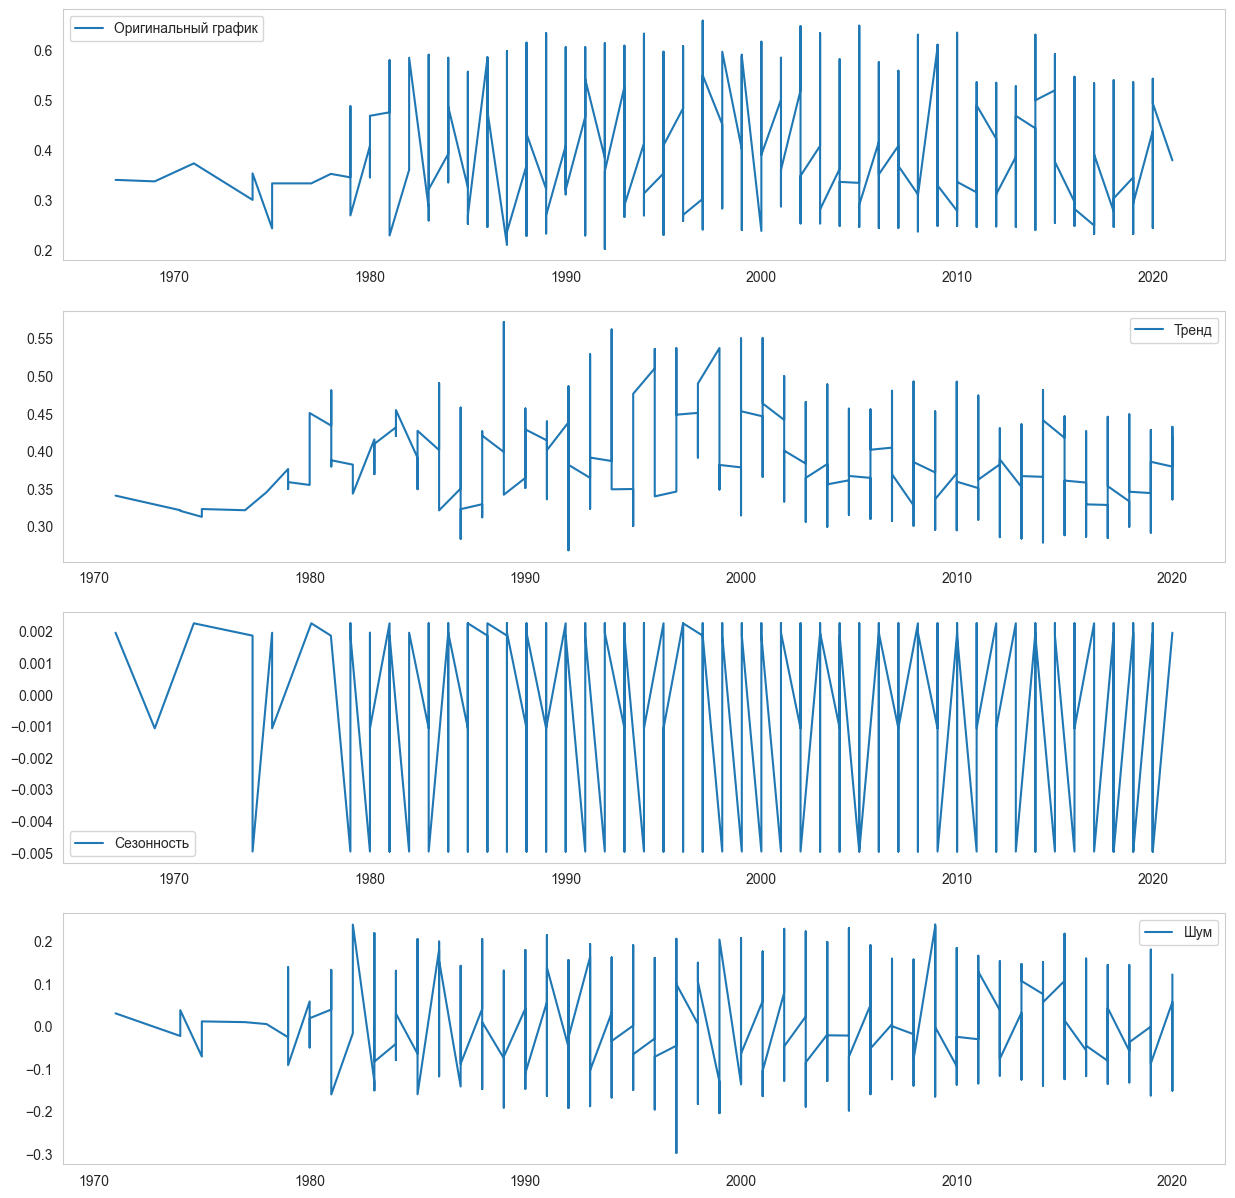

In [2038]:
analysis = AnalyserTimeSeriesCustom(df[target])
analysis.decompositon(model='add', period=period)

## автокорреляционное разложение

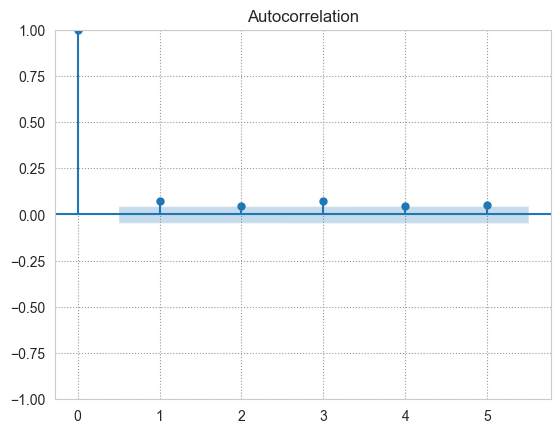

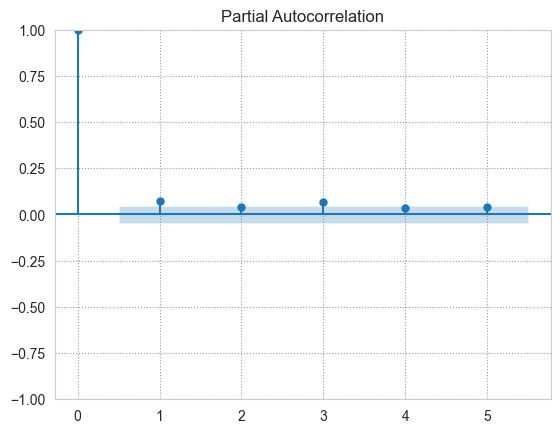

In [2039]:
analysis.auto_correlation(period)

## подготовка эндогенных рядов

In [2040]:
mask_usa = df['country_code'] == 'USA'
df_usa = df[mask_usa]
df_usa = df_usa.rename(columns={'value': 'usa_value'})

In [2041]:
df = df[~mask_usa]

## подготовка данных для обучения

In [2042]:
df['country_code'], _ = Encoder.labelEncoder(df['country_code'])
df['region'], _ = Encoder.labelEncoder(df['region'])

In [2043]:
separate_point = int(len(df) * 0.75)

y_train = df[target][:separate_point]
y_test = df[target][separate_point:]

X_train = df.drop(columns=target)[:separate_point]
X_test = df.drop(columns=target)[separate_point:]

## модель XGB

In [2044]:
# df = df.join(df_usa[['usa_value']], how='left')

In [2045]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

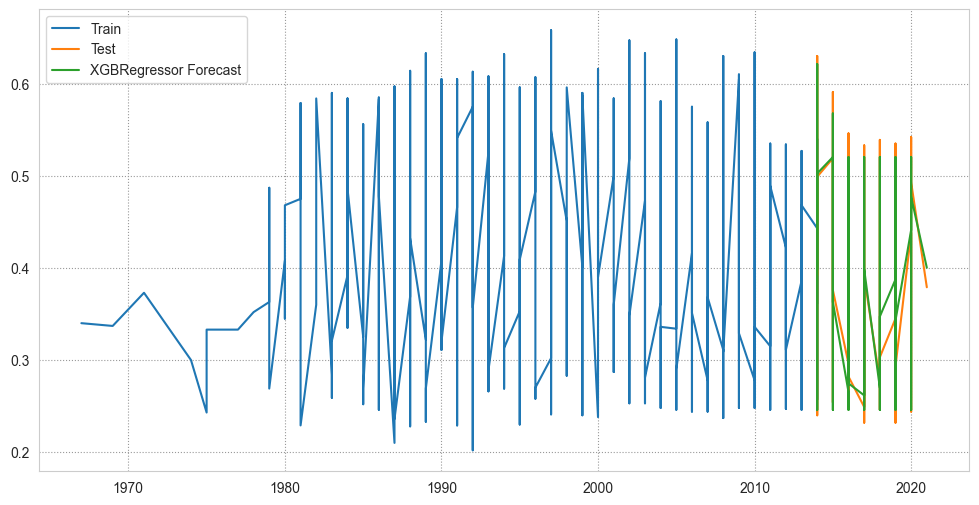

R²: 0.881
MAE: 0.02
MAPE: 0%
RMSE: 0
MSE: 0


In [2046]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='XGBRegressor Forecast')
plt.legend()
plt.show()

MetricCalculator.show_regression_metrics(y_test, y_pred)

## модель VARMAX

In [2047]:
train_data = df.iloc[:separate_point]
test_data = df.iloc[separate_point:]

# Объединяем по индексу (времени)
endog_train = train_data[['value']].copy()
endog_train['usa_value'] = df_usa['usa_value'].reindex(train_data.index)

endog_test = test_data[['value']].copy()
endog_test['usa_value'] = df_usa['usa_value'].reindex(test_data.index)


exog_train = train_data[['region', 'country_code']]
exog_test = test_data[['region', 'country_code']]

model = VARMAX(endog=endog_train, exog=exog_train, order=(1, 1))
model_fitted = model.fit(disp=True)

forecast_interval = len(test_data)
forecast = model_fitted.forecast(steps=forecast_interval, exog=exog_test) 
print(forecast)

C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         value  usa_value
1398  0.387910   0.414500
1399  0.439960   0.414256
1400  0.334027   0.413990
1401  0.326850   0.413783
1402  0.437298   0.413572
...        ...        ...
1859  0.437545   0.401825
1860  0.331740   0.401802
1861  0.438740   0.401797
1862  0.442269   0.401766
1863  0.385802   0.401750

[466 rows x 2 columns]


C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning:

In [2048]:
print(model_fitted.summary())

                             Statespace Model Results                             
Dep. Variable:     ['value', 'usa_value']   No. Observations:                 1398
Model:                        VARMAX(1,1)   Log Likelihood                8364.406
                              + intercept   AIC                         -16694.813
Date:                    Mon, 14 Apr 2025   BIC                         -16605.685
Time:                            13:46:55   HQIC                        -16661.492
Sample:                                 0                                         
                                   - 1398                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):              0.00, nan   Jarque-Bera (JB):     8.21, 1129713.47
Prob(Q):                         0.95, nan   Prob(JB):                   0.02, 0.00
Heteroskedasticity (H):         0.58, 0.24   Skew:                       0.14, 2.34
P

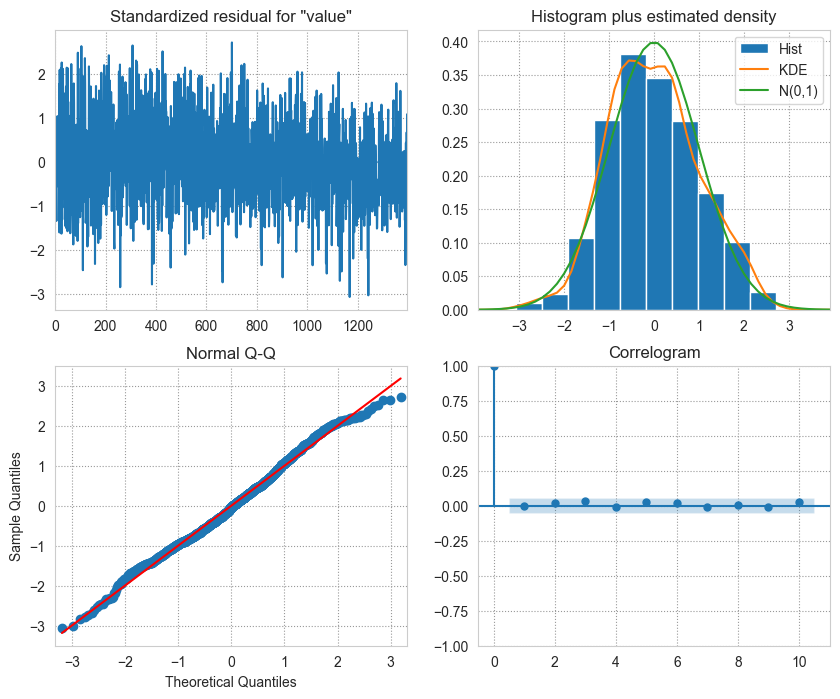

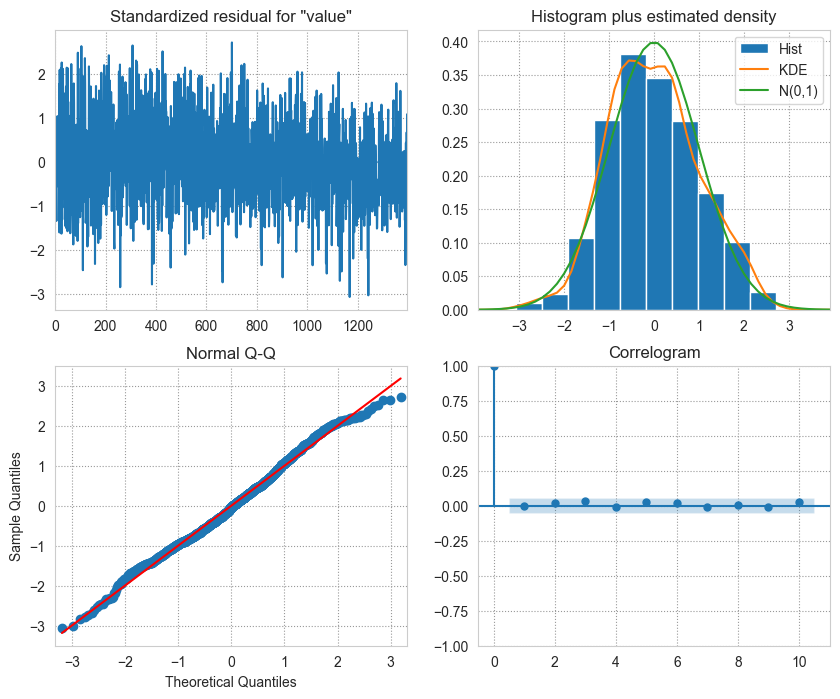

In [2049]:
model_fitted.plot_diagnostics(figsize=(10, 8))

In [2050]:
y_pred = forecast.iloc[:, 0].values
y_test = df['value'].iloc[-forecast_interval:]

MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.376
MAE: 0.05
MAPE: 0%
RMSE: 0
MSE: 0


## модель LSTM

In [2051]:
y = df[target].values
X = df.drop(columns=target).values

n_past = 30
lstm_separate_point = 8

# Нарезаем данные для обучения
X_train = []
y_train = []

for i in range(n_past, len(X) - lstm_separate_point):
    X_train.append(X[i-n_past:i, :]) 
    y_train.append(y[i])

X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1,1)

X_test = []
y_test = []

for i in range(len(X) - lstm_separate_point, len(X)):
    X_test.append(X[i-n_past:i, :]) 
    y_test.append(y[i])

X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1,1)

original_shape = X_train.shape
X_train_2d = X_train.reshape(-1, original_shape[2])
scaler = MinMaxScaler()
X_train_norm_2d = scaler.fit_transform(X_train_2d)
X_train_norm = X_train_norm_2d.reshape(original_shape) 

original_shape = X_test.shape
X_test_2d = X_test.reshape(-1, original_shape[2])
scaler = MinMaxScaler()
X_test_norm_2d = scaler.fit_transform(X_test_2d)
X_test_norm = X_test_norm_2d.reshape(original_shape) 


In [2052]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train_norm.shape[1],X_train_norm.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(y_train.shape[1]))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

model.fit(X_train_norm, y_train, epochs=20, batch_size=32, shuffle=False, validation_split=0.1)
y_pred = model.predict(X_test_norm)


Epoch 1/20


C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1252 - root_mean_squared_error: 0.3356 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0747
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0189 - root_mean_squared_error: 0.1359 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160 - root_mean_squared_error: 0.1257 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1202 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - root_mean_squared_error: 0.1177 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - root_mean_squared_error: 0.1135 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124 - root_me

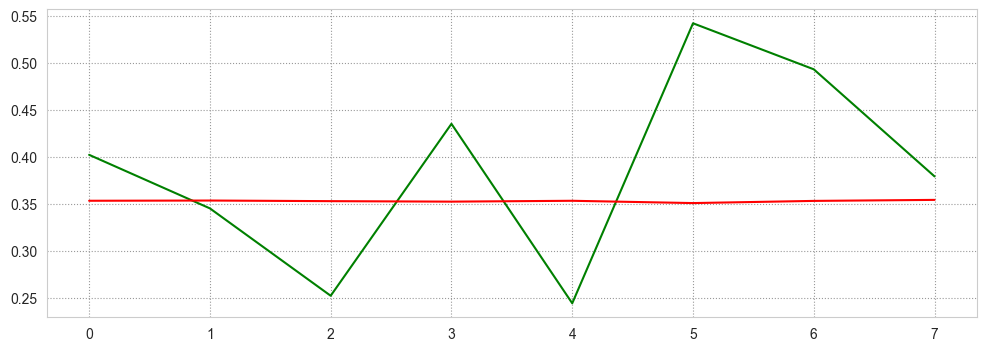

R²: -0.127
MAE: 0.09
MAPE: 0%
RMSE: 0
MSE: 0


In [2053]:
plt.figure(figsize=(12,4))
plt.plot(y_test, color='g')
plt.plot(y_pred, color='r')
plt.show()

MetricCalculator.show_regression_metrics(y_test, y_pred)